In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
from scipy import ndimage
import random
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
!tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

/bin/sh: -c: line 0: syntax error near unexpected token `tf.compat.v1.logging.ERROR'
/bin/sh: -c: line 0: `tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)'


In [3]:
with open('X_train.pickle', 'rb') as f:
    X_train = pickle.load(f)
with open('X_test.pickle', 'rb') as f:
    X_test = pickle.load(f)

In [4]:
print('X Train lenght: ', len(X_train))
print('X Test length: ', len(X_test))

X Train lenght:  918
X Test length:  393


In [5]:
rec_df = pd.read_csv('Binary_data.csv')


In [6]:
y_train_facial = rec_df['Recognizable-Facial-Feature'][:len(X_train)]
y_test_facial = rec_df['Recognizable-Facial-Feature'][len(X_train):]

y_train_brain = rec_df['Brain-Feature-Loss'][:918]
y_test_brain = rec_df['Brain-Feature-Loss'][918:]

In [7]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def test_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


In [8]:

train_loader_facial = tf.data.Dataset.from_tensor_slices((X_train, y_train_facial))
test_loader_facial = tf.data.Dataset.from_tensor_slices((X_test, y_test_facial))


train_loader_brain = tf.data.Dataset.from_tensor_slices((X_train, y_train_brain))
test_loader_brain = tf.data.Dataset.from_tensor_slices((X_test, y_test_brain))

In [9]:
batch_size = 16
# Augment the on the fly during training.
train_dataset_facial = (
    train_loader_facial.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
test_dataset_facial = (
    test_loader_facial.shuffle(len(X_test))
    .map(test_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)


# Augment the on the fly during training.
train_dataset_brain = (
    train_loader_brain.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
test_dataset_brain = (
    test_loader_brain.shuffle(len(X_test))
    .map(test_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is: (128, 128, 64, 1)


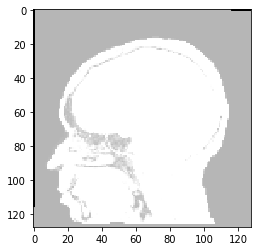

In [22]:
import numpy
data = test_dataset_facial.take(4)
images, labels = list(data)[0]
images = images.numpy()
image = images[10]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

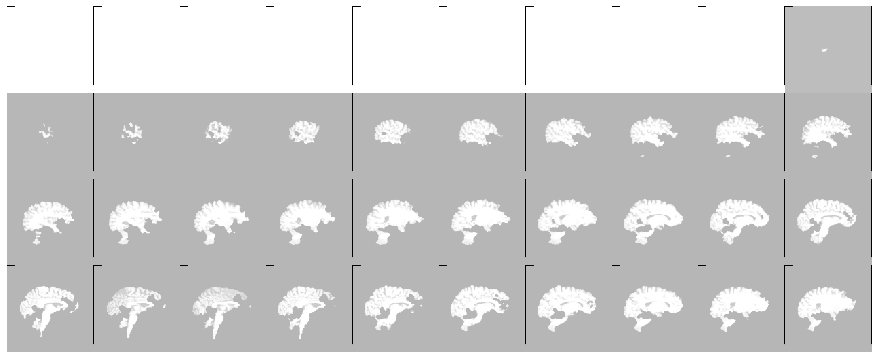

In [10]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

In [11]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""    
    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 16)  448       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 16)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 16)    64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 32)    13856     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 32)    128   

In [12]:
initial_learning_rate = 0.00001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "Facial_feature_model.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 20
model.fit(
    train_dataset_facial,
    validation_data=test_dataset_facial,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/20
58/58 [==============================] - 141s 2s/step - loss: 0.7172 - acc: 0.3972 - val_loss: 0.7042 - val_acc: 0.2494
Epoch 2/20
58/58 [==============================] - 136s 2s/step - loss: 0.5629 - acc: 0.9482 - val_loss: 0.6557 - val_acc: 0.7506
Epoch 3/20
58/58 [==============================] - 137s 2s/step - loss: 0.4575 - acc: 0.9762 - val_loss: 0.5770 - val_acc: 0.7506
Epoch 4/20
58/58 [==============================] - 136s 2s/step - loss: 0.3914 - acc: 0.9708 - val_loss: 0.5164 - val_acc: 0.7506
Epoch 5/20
58/58 [==============================] - 135s 2s/step - loss: 0.3402 - acc: 0.9784 - val_loss: 0.4827 - val_acc: 0.7506
Epoch 6/20
58/58 [==============================] - 135s 2s/step - loss: 0.3031 - acc: 0.9756 - val_loss: 0.4563 - val_acc: 0.7506
Epoch 7/20
58/58 [==============================] - 134s 2s/step - loss: 0.2788 - acc: 0.9738 - val_loss: 0.4165 - val_acc: 0.7506
Epoch 8/20
58/58 [==============================] - 135s 2s/step - loss: 0.2687 - a

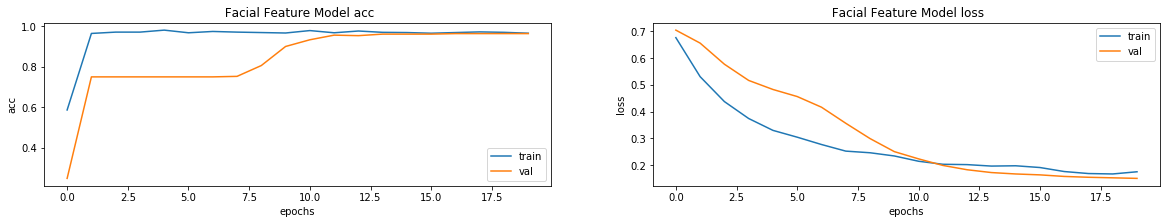

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title(" Facial Feature Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
initial_learning_rate = 0.00001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "Brain_Loss_model.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 20
model.fit(
    train_dataset_brain,
    validation_data=test_dataset_brain,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/20
58/58 [==============================] - 141s 2s/step - loss: 0.6581 - acc: 0.6897 - val_loss: 0.6708 - val_acc: 0.7328
Epoch 2/20
58/58 [==============================] - 137s 2s/step - loss: 0.4918 - acc: 0.9587 - val_loss: 0.6076 - val_acc: 0.7328
Epoch 3/20
58/58 [==============================] - 135s 2s/step - loss: 0.3897 - acc: 0.9767 - val_loss: 0.5366 - val_acc: 0.7328
Epoch 4/20
58/58 [==============================] - 135s 2s/step - loss: 0.3415 - acc: 0.9498 - val_loss: 0.5033 - val_acc: 0.7328
Epoch 5/20
58/58 [==============================] - 134s 2s/step - loss: 0.3008 - acc: 0.9557 - val_loss: 0.4962 - val_acc: 0.7328
Epoch 6/20
58/58 [==============================] - 134s 2s/step - loss: 0.2724 - acc: 0.9729 - val_loss: 0.4709 - val_acc: 0.7328
Epoch 7/20
58/58 [==============================] - 134s 2s/step - loss: 0.2690 - acc: 0.9712 - val_loss: 0.4158 - val_acc: 0.7328
Epoch 8/20
58/58 [==============================] - 134s 2s/step - loss: 0.2235 - a

NameError: name 'model' is not defined

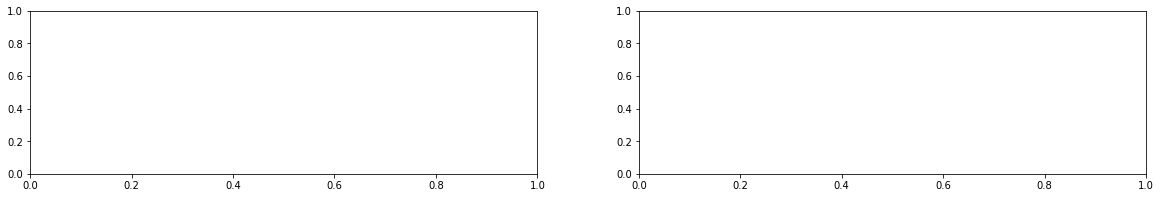

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Brain Loss Feature| Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [1]:
predicted_facial = []
model = keras.models.load_model('Facial_feature_model.h5')
model.load_weights("Facial_feature_model.h5")

for i in range(len(X_test)):
    prediction = model.predict(np.expand_dims(X_test[i], axis=0))[0]
    if prediction >= 0.50:
        predicted_facial.append(1)
    else:
        predicted_facial.append(0)

NameError: name 'keras' is not defined

In [23]:
predicted_brain = []
model = keras.models.load_model('Brain_Loss_model.h5')
model.load_weights("Brain_Loss_model.h5")

for i in range(len(X_test)):
    prediction = model.predict(np.expand_dims(X_test[i], axis=0))[0]
    if prediction >= 0.50:
        predicted_brain.append(1)
    else:
        predicted_brain.append(0)

In [24]:
tn, fp, fn, tp = confusion_matrix(y_test_facial, predicted_facial).ravel()

In [25]:
tn, fp, fn, tp

(288, 7, 7, 91)

In [26]:
tn, fp, fn, tp = confusion_matrix(y_test_brain, predicted_brain).ravel()

In [27]:
tn, fp, fn, tp

(105, 0, 287, 1)